# Word Embedding for Sequence Processing

**The goal of this practical is to use pre-trained word embedding for adressing the sequence prediction tasks studied in week 2: PoS and chunking.**

In [90]:
import numpy as np
import gensim.downloader as api
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt

## 0) Loading PoS (or chunking) datasets (small or large)

In [91]:
def load(filename):
    listeDoc = list()
    with open(filename, "r") as f:
        doc = list()
        for ligne in f:
            #print "l : ",len(ligne)," ",ligne
            if len(ligne) < 2: # fin de doc
                listeDoc.append(doc)
                doc = list()
                continue
            mots = ligne.replace("\n","").split(" ")
            doc.append((mots[0],mots[1])) # mettre mots[2] à la place de mots[1] pour le chuncking
    return listeDoc

In [92]:
bSmall = True

if(bSmall==True):
    filename = "datasets/conll2000/chtrain.txt" 
    filenameT = "datasets/conll2000/chtest.txt" 

else:
    # Larger corpus .
    filename = "datasets/conll2000/train.txt" 
    filenameT = "datasets/conll2000/test.txt" 

alldocs = load(filename)
alldocsT = load(filenameT)

print(len(alldocs)," docs read")
print(len(alldocsT)," docs (T) read")

823  docs read
77  docs (T) read


# 1) Word embedding for classifying each word

### Pre-trained word2vec

In [93]:
import gensim.downloader as api
bload = True
fname = "word2vec-google-news-300"
sdir = "" # Change

if(bload==True):
    wv_pre_trained = KeyedVectors.load(sdir+fname+".dat")
else:    
    wv_pre_trained = api.load(fname)
    wv_pre_trained.save(sdir+fname+".dat")

### Some token on the dataset are missing, we will encode them with a random vector
This is sub-optimal, but we need to do something

In [94]:
def randomvec():
    default = np.random.randn(300)
    default = default  / np.linalg.norm(default)
    return default

In [95]:
np.random.seed(seed=10) # seed the randomness

dictadd = dict()
cpt=0
for d in alldocs:
    cpt+=1
    print(" ****** Document ******",cpt)
    for (x,pos) in d:
        if (not (x in wv_pre_trained) and not (x in dictadd)):
            print(x," not in WE, adding it with random vector")
            dictadd[x] = randomvec()
            
for d in alldocsT:
    cpt+=1
    print(" ****** TEST Document ******",cpt)
    for (x,pos) in d:
        if (not (x in wv_pre_trained) and not (x in dictadd)):
            print(x," not in WE, adding it with random vector")
            dictadd[x] = randomvec()
            #wv_pre_trained.add_vector(x,randomvec())
            

 ****** Document ****** 1
's  not in WE, adding it with random vector
a  not in WE, adding it with random vector
to  not in WE, adding it with random vector
747  not in WE, adding it with random vector
.  not in WE, adding it with random vector
 ****** Document ****** 2
200  not in WE, adding it with random vector
so-called  not in WE, adding it with random vector
 ****** Document ****** 3
,  not in WE, adding it with random vector
and  not in WE, adding it with random vector
 ****** Document ****** 4
793  not in WE, adding it with random vector
of  not in WE, adding it with random vector
 ****** Document ****** 5
 ****** Document ****** 6
 ****** Document ****** 7
59  not in WE, adding it with random vector
 ****** Document ****** 8
 ****** Document ****** 9
SHEARSON  not in WE, adding it with random vector
 ****** Document ****** 10
42  not in WE, adding it with random vector
Balcor  not in WE, adding it with random vector
 ****** Document ****** 11
 ****** Document ****** 12
 ******

In [96]:
np.random.seed(seed=10) # seed the randomness

dictadd = dict()
cpt=0
i = 0
for d in alldocs:
    cpt+=1
    #print(" ****** Document ******",cpt)
    for (x,pos) in d:
        if (not (x in wv_pre_trained) and not (x in dictadd)):
            #print(x," not in WE, adding it with random vector")
            i += 1
            dictadd[x] = randomvec()
print('Random vectors :', i)
    

i = 0
for d in alldocsT:
    cpt+=1
    #print(" ****** TEST Document ******",cpt)
    for (x,pos) in d:
        if (not (x in wv_pre_trained) and not (x in dictadd)):
            #print(x," not in WE, adding it with random vector")
            i += 1
            dictadd[x] = randomvec()
print('Random vectors test :', i)

Random vectors : 528
Random vectors test : 45


### Add the (key-value) 'random' word embeddings for missing inputs

In [97]:
wv_pre_trained.add_vectors(list(dictadd.keys()), list(dictadd.values()))

### Store the train and test datasets: a word embedding for each token in the sequences

In [98]:
wvectors = [wv_pre_trained[word] for doc in alldocs for word, tag in doc]
wvectorsT = [wv_pre_trained[word] for doc in alldocsT for word, tag in doc]

### Check the size of your train/test datasets

In [99]:
len(wvectors), len(wvectorsT)

(19172, 1896)

### Collecting train/test labels

In [100]:
# Labels train/test

buf2 = [[pos for m,pos in d ] for d in alldocs]
cles = []
[cles.extend(b) for b in buf2]
cles = np.unique(np.array(cles))
cles2ind = dict(zip(cles,range(len(cles))))
nCles = len(cles)
print(nCles," keys in the dictionary")

labels  = np.array([cles2ind[pos] for d in alldocs for (m,pos) in d ])
#np.array([cles2ind[pos] for (m,pos) in d for d in alldocs])
labelsT  = np.array([cles2ind.setdefault(pos,len(cles)) for d in alldocsT for (m,pos) in d ])

print(len(cles2ind)," keys in the dictionary")

42  keys in the dictionary
43  keys in the dictionary


In [101]:
print(labels.shape)
print(labelsT.shape)

(19172,)
(1896,)


### Train a Logistic Regression Model : 

In [102]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression()
lr.fit(wvectors, labels)

labelsP = lr.predict(wvectorsT)
accuracy_score(labelsP, labelsT)

0.9129746835443038

### Train with differents models and compare them :

LogisticRegression : Accuracy = 0.9129746835443038
GaussianNB : Accuracy = 0.734704641350211
SVC : Accuracy = 0.9166666666666666
RandomForestClassifier : Accuracy = 0.8918776371308017


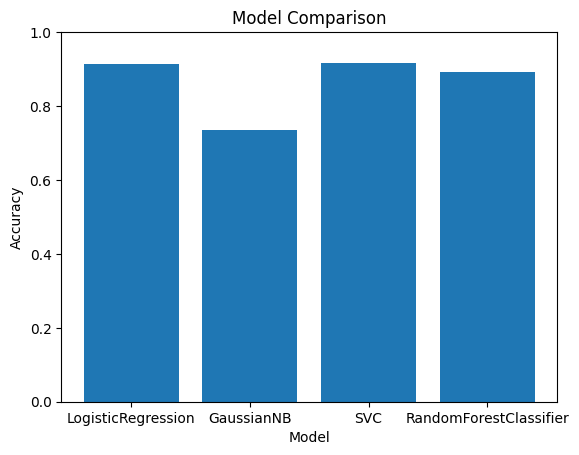

In [106]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Define models
models = [
    LogisticRegression(),
    GaussianNB(),
    SVC(),
    RandomForestClassifier(),
]

# Train and evaluate models
accuracies = []

for model in models:
    model.fit(wvectors, labels)
    labels_pred = model.predict(wvectorsT)
    accuracy = accuracy_score(labels_pred, labelsT)
    accuracies.append(accuracy)

# Plot the results
model_names = [type(model).__name__ for model in models]

for i in range(len(models)) :
    print(f"{type(models[i]).__name__} : Accuracy = {accuracies[i]}")

plt.bar(model_names, accuracies)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.ylim([0, 1])
plt.show()

# 2) Using word embedding with CRF

## We will define the following features functions for CRF

In [107]:
def features_wv(sentence, index):
    v = wv_pre_trained.get_vector(sentence[index])
    d = {'f'+str(i):v[i] for i in range(300)}
    return d

def features_structural(sentence, index):
    return {
        'word': sentence[index],
        'is_first': index == 0,
        'is_last': index == len(sentence) - 1,
        'is_capitalized': sentence[index][0].upper() == sentence[index][0],
        'is_all_caps': sentence[index].upper() == sentence[index],
        'is_all_lower': sentence[index].lower() == sentence[index],
        'prefix-1': sentence[index][0],
        'prefix-2': sentence[index][:2],
        'prefix-3': sentence[index][:3],
        'suffix-1': sentence[index][-1],
        'suffix-2': sentence[index][-2:],
        'suffix-3': sentence[index][-3:],
        'prev_word': '' if index == 0 else sentence[index - 1],
        'next_word': '' if index == len(sentence) - 1 else sentence[index + 1],
        'has_hyphen': '-' in sentence[index],
        'is_numeric': sentence[index].isdigit(),
     ## We will define the following features functions for CRF## We will define the following features functions for CRF   'capitals_inside': sentence[index][1:].lower() != sentence[index][1:]
    }
def features_wv_plus_structural(sentence, index):
    v = wv_pre_trained.get_vector(sentence[index]) 
    d = {'f'+str(i):v[i] for i in range(300)}

    return {**d, **features_structural(sentence, index)}

## [Question]: explain what the 3 feature functions encode and what their differences are

<font color=yellow>
La fonction features_wv encode les words embedings pour un mot donné dans une phrase. Elle utilise un modèle de word embeding pré-entraîné pour récupérer une représentation vectorielle pour le mot. La fonction crée un dictionnaire avec des clés de f0 à f299, où chaque clé représente une dimension du vecteur du word embeding. Cette fonction capture la similarité sémantique entre les mots, car les mots ayant des significations similaires ont tendance à avoir des représentations vectorielles similaires dans l'espace d'embedding.
<br>

La fonction features_structural encode les caractéristiques structurelles d'un mot donné dans une phrase. Elle crée un dictionnaire avec des clés qui codent différents aspects du mot, tels que sa position dans la phrase, la capitalisation, les préfixes et suffixes, les mots adjacents et d'autres propriétés comme la présence de tirets ou de chiffres numériques. Cette fonction capture les propriétés syntaxiques et morphologiques des mots dans la phrase.
<br>

La fonction features_wv_plus_structural combine les words embedings et les caractéristiques structurelles en concaténant leurs dictionnaires respectifs. Elle crée un nouveau dictionnaire avec des clés qui représentent à la fois les dimensions du vecteur d'embedding de mots et les caractéristiques structurelles du mot. Cette fonction capture à la fois les propriétés sémantiques et syntactiques/morphologiques des mots dans la phrase.

<font>

### You can now train a CRF with the 3 features and analyse the results

In [118]:
from nltk.tag.crf import CRFTagger

fct = features_wv
tagger = CRFTagger(feature_func=fct)
## Train the model
tagger.train(alldocs, 'model_w2v_crf_1')

## Evaluate performances
accuracy_wv = tagger.accuracy(alldocsT)
print(f"{fct.__annotations__} : {accuracy_wv}")

In [116]:
fct = features_structural
tagger = CRFTagger(feature_func=fct)
## Train the model
tagger.train(alldocs, 'model_w2v_crf_2')

## Evaluate performances
accuracy_structural = tagger.accuracy(alldocsT)
print(f"{fct.__annotations__} : {accuracy_structural}")

<function features_structural at 0x00000289F3C70FE0> : 0.929324894514768


In [117]:
fct = features_wv_plus_structural
tagger = CRFTagger(feature_func=features_wv_plus_structural)
## Train the model
tagger.train(alldocs, 'model_w2v_crf_1')

## Evaluate performances
accuracy_wv_plus_structural = tagger.accuracy(alldocsT)
print(f"{fct.__annotations__} : {accuracy_wv_plus_structural}")

<function features_wv_plus_structural at 0x00000289C95867A0> : 0.9583333333333334


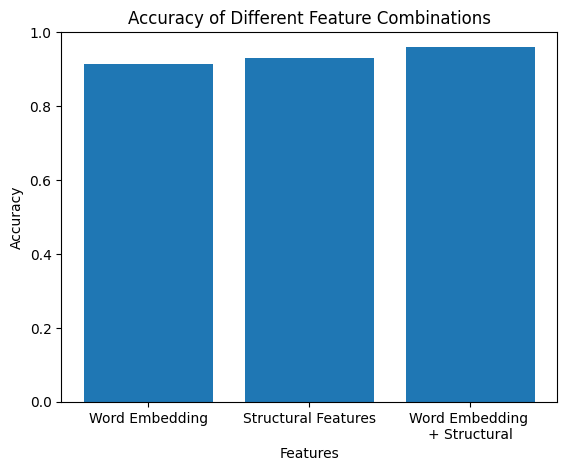

In [111]:
# Plot the results
labels = ['Word Embedding', 'Structural Features', 'Word Embedding \n+ Structural']
accuracy_values = [accuracy_wv, accuracy_structural, accuracy_wv_plus_structural]

plt.bar(labels, accuracy_values)
plt.xlabel('Features')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Feature Combinations')
plt.ylim([0, 1])  # Set the y-axis limits between 0 and 1
plt.show()